In [6]:
!pip install scikit-image


In [7]:

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu, threshold_sauvola
from sklearn.metrics import jaccard_score


In [8]:

DATA_PATH = "/kaggle/input/brain-tumor-segmentation"

images_path = os.path.join(DATA_PATH, "images")
masks_path = os.path.join(DATA_PATH, "masks")

image_list = sorted(os.listdir(images_path))
mask_list = sorted(os.listdir(masks_path))

print("Total Images:", len(image_list))


Total Images: 3064


In [9]:

def dice_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    intersection = np.sum((y_true == 255) & (y_pred == 255))
    return (2.0 * intersection) / (
        np.sum(y_true == 255) + np.sum(y_pred == 255) + 1e-8
    )


In [10]:

def run_segmentation_experiment(image_list, mask_list, images_path, masks_path):

    dice_otsu_all = []
    dice_sauvola_all = []

    jacc_otsu_all = []
    jacc_sauvola_all = []

    for img_name, mask_name in tqdm(zip(image_list, mask_list), total=len(image_list)):

        image = cv2.imread(os.path.join(images_path, img_name), 0)
        mask  = cv2.imread(os.path.join(masks_path, mask_name), 0)

        # OTSU
        t_otsu = threshold_otsu(image)
        otsu_seg = (image > t_otsu).astype(np.uint8) * 255

        # SAUVOLA
        t_sauvola = threshold_sauvola(image, window_size=25)
        sauvola_seg = (image > t_sauvola).astype(np.uint8) * 255

        d_otsu = dice_score(mask, otsu_seg)
        d_sauv = dice_score(mask, sauvola_seg)

        j_otsu = jaccard_score((mask.flatten() == 255).astype(int),
                                (otsu_seg.flatten() == 255).astype(int))

        j_sauv = jaccard_score((mask.flatten() == 255).astype(int),
                                (sauvola_seg.flatten() == 255).astype(int))

        dice_otsu_all.append(d_otsu)
        dice_sauvola_all.append(d_sauv)

        jacc_otsu_all.append(j_otsu)
        jacc_sauvola_all.append(j_sauv)

    return (np.array(dice_otsu_all),
            np.array(dice_sauvola_all),
            np.array(jacc_otsu_all),
            np.array(jacc_sauvola_all))


In [11]:

dice_otsu_all, dice_sauvola_all, jacc_otsu_all, jacc_sauvola_all = run_segmentation_experiment(
    image_list, mask_list, images_path, masks_path
)

print("Otsu Dice:", np.mean(dice_otsu_all))
print("Otsu Jaccard:", np.mean(jacc_otsu_all))

print("\nSauvola Dice:", np.mean(dice_sauvola_all))
print("Sauvola Jaccard:", np.mean(jacc_sauvola_all))


100%|██████████| 3064/3064 [04:08<00:00, 12.31it/s]

Otsu Dice: 0.07074164298403321
Otsu Jaccard: 0.03764597896852798

Sauvola Dice: 0.04628172085616832
Sauvola Jaccard: 0.024083547293960055


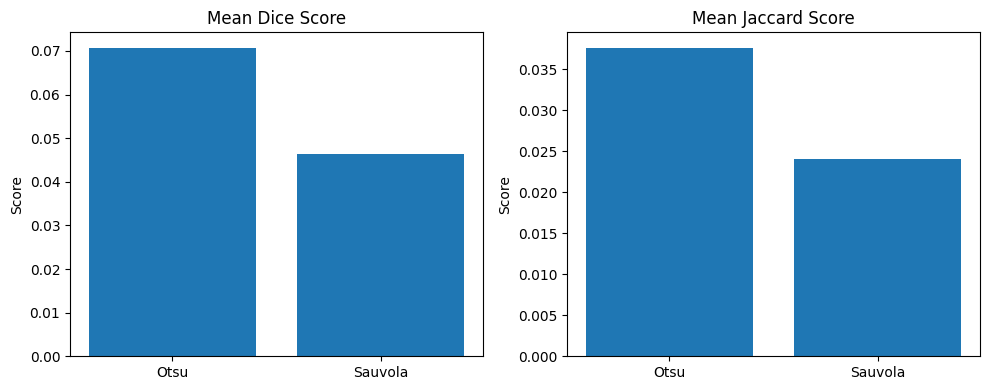

In [12]:

# Visual comparison of global results

methods = ["Otsu", "Sauvola"]
mean_dice = [np.mean(dice_otsu_all), np.mean(dice_sauvola_all)]
mean_jacc = [np.mean(jacc_otsu_all), np.mean(jacc_sauvola_all)]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(methods, mean_dice)
plt.title("Mean Dice Score")
plt.ylabel("Score")

plt.subplot(1,2,2)
plt.bar(methods, mean_jacc)
plt.title("Mean Jaccard Score")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


/tmp/ipykernel_55/1263278392.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dice_otsu_all, dice_sauvola_all], labels=["Otsu", "Sauvola"])
/tmp/ipykernel_55/1263278392.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([jacc_otsu_all, jacc_sauvola_all], labels=["Otsu", "Sauvola"])


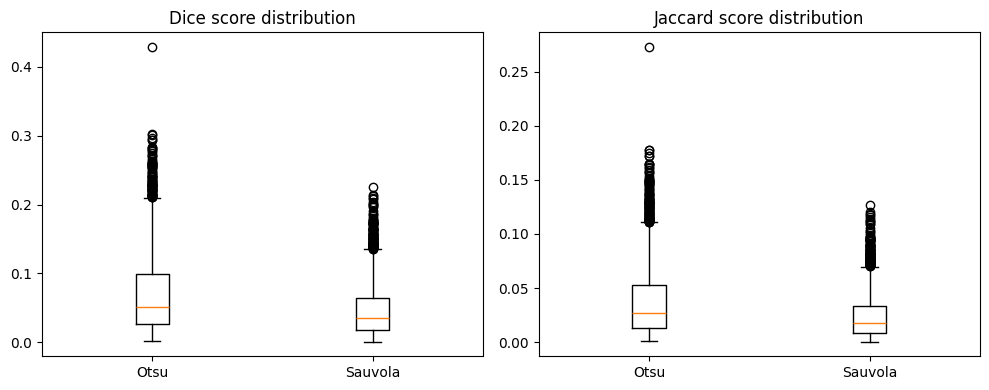

In [13]:

# Distribution comparison (extra visual representation)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.boxplot([dice_otsu_all, dice_sauvola_all], labels=["Otsu", "Sauvola"])
plt.title("Dice score distribution")

plt.subplot(1,2,2)
plt.boxplot([jacc_otsu_all, jacc_sauvola_all], labels=["Otsu", "Sauvola"])
plt.title("Jaccard score distribution")

plt.tight_layout()
plt.show()


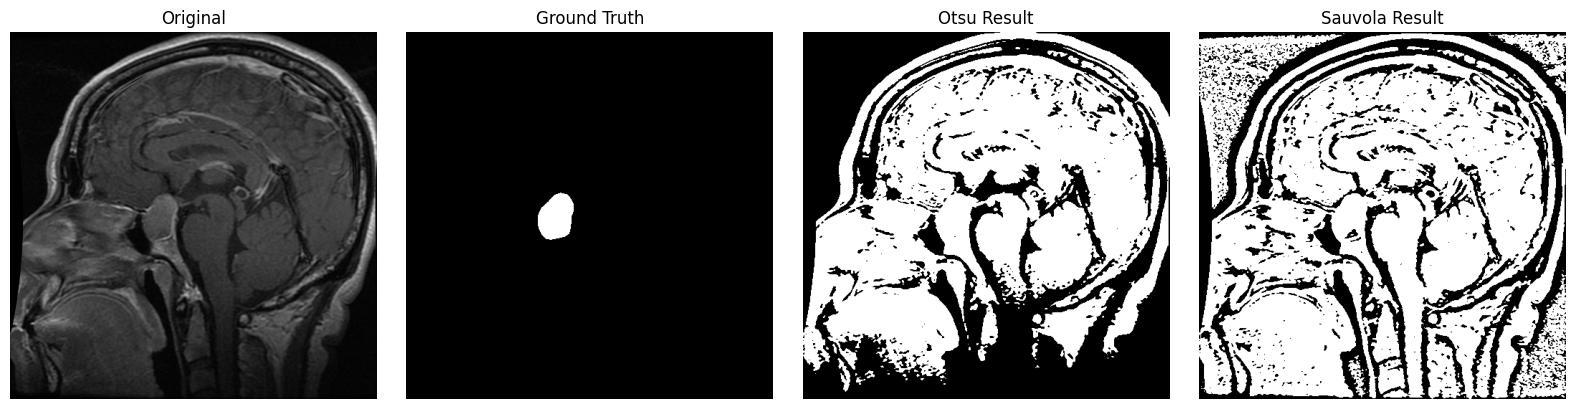

In [14]:

# Sample qualitative comparison

idx = 200

image = cv2.imread(os.path.join(images_path, image_list[idx]), 0)
mask  = cv2.imread(os.path.join(masks_path, mask_list[idx]), 0)

t_otsu = threshold_otsu(image)
otsu_seg = (image > t_otsu).astype(np.uint8) * 255

t_sauvola = threshold_sauvola(image, window_size=25)
sauvola_seg = (image > t_sauvola).astype(np.uint8) * 255

plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(otsu_seg, cmap="gray")
plt.title("Otsu Result")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(sauvola_seg, cmap="gray")
plt.title("Sauvola Result")
plt.axis("off")

plt.tight_layout()
plt.show()


Final Results and Discussion:* 

Otsu Dice Score     : 0.07074164298403321
Otsu Jaccard Index : 0.03764597896852798

Sauvola Dice Score     : 0.04628172085616832
Sauvola Jaccard Index : 0.024083547293960055

Observation:

Otsu thresholding gives higher Dice and Jaccard values than Sauvola for this dataset.

Both methods show low overlap with the ground truth because brain tumor regions are very small and have low contrast compared to the whole MRI image.

Global thresholding (Otsu) performs slightly better than local adaptive thresholding (Sauvola) for this particular dataset.

Conclusion:

This experiment shows that simple threshold-based segmentation methods are not sufficient for accurate brain tumor segmentation.
However, Otsu performs marginally better than Sauvola in terms of Dice and Jaccard scores on the given dataset.